In [1]:
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTMCell
from keras.layers import Input, RNN, Concatenate 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.optimizers import RMSprop
from keras.optimizers import SGD, Adam
from urllib.request import urlretrieve
import unidecode
import numpy as np
import random
import sys
import re, cgi
import glob
import cv2

Using TensorFlow backend.


In [2]:
import os
base_dir = 'LSTMimages'

In [3]:
image_folders = os.listdir(base_dir)
image_names = []
for folder in image_folders:
    image_loc = os.path.join(base_dir, folder)
    for s in os.listdir(image_loc):
        image_names.append(folder +'\\'+ s)

In [4]:
from sklearn.utils import shuffle

filenames_shuffled = shuffle(image_names)
filenames_shuffled_numpy = np.array(filenames_shuffled)

In [5]:
from sklearn.model_selection import train_test_split
X_train_filenames, X_test_filenames = train_test_split(
    filenames_shuffled_numpy, test_size=0.2, random_state=1)

print(X_train_filenames.shape) # (55196,)

print(X_test_filenames.shape)   # (13799,)

(1025,)
(257,)


In [68]:
#Halo architekturajanak meghatarazosa
lstm_n=[128]
img_height=88
N_fc1k=128 # dekoder cella kimenetere uletett MLP rejtett retegenek merete
patience = 10
# optimalizalo eljaras kivalasztasa es felparameterezese
lr=0.001
wd = 0 

epochs = 50
batch_size = 256
N_input = 100
N_output = 20
steps = 5000
w_step = 3

In [62]:
train_width = 0
test_width = 0
for i in X_train_filenames:
    train_width += (cv2.imread('c:/NHF/LSTMimages/' + str(i), cv2.IMREAD_UNCHANGED).shape[1] - N_input - N_output)/w_step
for i in X_test_filenames:
    test_width += (cv2.imread('c:/NHF/LSTMimages/' + str(i), cv2.IMREAD_UNCHANGED).shape[1] - N_input - N_output)/w_step

In [63]:
def img_data_gen(batch, steps, N_input, N_output, image_filenames, w_step):
    
    img_idx = 0
    window_idx = 0
    
    while True:
        img_idx = 0
        window_idx = 0
        img = cv2.imread('c:/NHF/LSTMimages/' + str(image_filenames[img_idx]), cv2.IMREAD_UNCHANGED)/255.0
        #print("Filename: ", image_filenames[img_idx])
        img_width = img.shape[1]
        img_height = img.shape[0]
        for _ in range(steps):
            
            enk_in = []
            dek_out = []
            #print(idx, "th batch")
            for b in range(0,batch):
                enk_in.append(img[:, window_idx:window_idx + N_input])
                dek_out.append(img[:,window_idx + N_input:window_idx + N_input + N_output])
                window_idx += w_step

                if(window_idx >= img_width - N_input - N_output):
                    img_idx += 1
                    if(img_idx >= image_filenames.shape[0]):
                        img_idx = 0
                    img = cv2.imread('c:/NHF/LSTMimages/' + str(image_filenames[img_idx]), cv2.IMREAD_UNCHANGED)/255.0
                    #print("New filename: ", image_filenames[img_idx])
                    img_width = img.shape[1]
                    #print(self.img_width)
                    window_idx = 0
                    #print("New image idx: ",  self.curr_img_idx)
                    #print("b: ", b)
            enk_in = np.array(enk_in).reshape((batch, img_height, N_input))
            enk_in = np.swapaxes(enk_in, 1, 2)
            dek_out = np.array(dek_out).reshape((batch, img_height, N_output))
            dek_out = np.swapaxes(dek_out, 1, 2)
            dek_in = np.zeros((dek_out.shape[0], dek_out.shape[1], 88)) # itt biztos, hogy 1 lesz az utolso dim-ben?
             #print("Window: ", self.curr_window)
            #print("X.shape: ", batch_x.shape)
            
            #print("enk_bem:", enk_in.shape)
            #print("dek_kim:", dek_out.shape)
            #print("dek_bem:", dek_in.shape)
            
            #print("Y.shape: ", batch_y.shape)
            yield ([enk_in, dek_in], dek_out)
            

In [2]:
from keras import backend as K
alpha = 1.2
beta = 1
def customLoss2(y_true, y_pred):
    loss = 0
    loss = K.mean(alpha*K.sum(K.square(y_pred - y_true**(1/10000.0))*y_true**(1/10000.0)) +  beta*K.sum(K.square(y_pred))*(1 - y_true**(1/10000.0)))
    #print(y_pred[y_nn_idx,i])
    return loss

In [66]:
def build_model(cells, d_in, N_fc1k, lr, wd):

    # ENKODER definialasa:
    enc_in=Input(shape=(None, d_in))

    enc_cells = [] # lehetoseg lesz tobb cell stackelesere
    for n_neur in cells:
        enc_cells.append(LSTMCell(n_neur))

    encoder = RNN(enc_cells, return_state=True) # visszaadja a vegso allapotot is 
    enc_states = encoder(enc_in)[1:] # kimeneti lista elso eleme a valodi kimenet, a tobbi meg az allapotok

    # DEKODER definialasa:
    dec_in=Input(shape=(None, d_in))

    dec_cells = [] # itt is stackelni tudjuk majd a cellakat
    for n_neur in cells:
        dec_cells.append(LSTMCell(n_neur))
    
    decoder = RNN(dec_cells, return_sequences=True, return_state=True) # visszadja a cella kimeneti szekvenciajat, illetve a vegso allapotat
    dec_out = decoder(dec_in, initial_state=enc_states)[0] # megnezni, hogyan lehet koze FCN-t tenni

    # FCL-t tegyunk a vegere
    dec_fc1= Dense(N_fc1k, activation='relu')(dec_out)
    dec_fc2 = Dense(d_in, activation='sigmoid')(dec_fc1)

    # Hozzuk letre a modelt
    model = Model(inputs=[enc_in, dec_in], outputs=dec_fc2)
    model.compile(optimizer=Adam(lr=lr, decay=wd), loss=customLoss2, metrics=['mae', 'mse'])
    print(model.summary())
    
    return(model)

In [67]:
train_width/batch_size

12889.11328125

In [69]:
train_data_gen = img_data_gen(batch = batch_size, steps = steps, N_input = N_input, N_output = N_output, image_filenames = X_train_filenames, w_step = w_step)
valid_data_gen = img_data_gen(batch = batch_size, steps = steps//10, N_input = N_input, N_output = N_output, image_filenames = X_test_filenames, w_step = w_step)

In [70]:
model = build_model(cells = lstm_n, d_in = img_height, N_fc1k=N_fc1k, lr = lr, wd = wd)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 88)     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None, 88)     0                                            
__________________________________________________________________________________________________
rnn_7 (RNN)                     [(None, 128), (None, 111104      input_7[0][0]                    
__________________________________________________________________________________________________
rnn_8 (RNN)                     [(None, None, 128),  111104      input_8[0][0]                    
                                                                 rnn_7[0][1]                

In [71]:
early_stopping = EarlyStopping(patience=patience, verbose=1)
checkpoint = ModelCheckpoint(filepath = 'Seq2seqLSTM_100_20.hdf5', save_best_only=True, verbose=1)

In [72]:
history=model.fit_generator(train_data_gen, steps_per_epoch=steps, epochs=epochs, callbacks=[early_stopping, checkpoint], 
                              validation_data=valid_data_gen, validation_steps=steps//10)

Epoch 1/50
5000/5000 [==============================] - 566s 113ms/step - loss: 14466.6187 - mae: 0.0492 - mse: 0.0178 - val_loss: 11947.0068 - val_mae: 0.0463 - val_mse: 0.0150

Epoch 00001: val_loss improved from inf to 11947.00684, saving model to Seq2seqLSTM_100_20.hdf5
Epoch 2/50
5000/5000 [==============================] - 564s 113ms/step - loss: 13057.8432 - mae: 0.0433 - mse: 0.0150 - val_loss: 11701.4932 - val_mae: 0.0441 - val_mse: 0.0144

Epoch 00002: val_loss improved from 11947.00684 to 11701.49316, saving model to Seq2seqLSTM_100_20.hdf5
Epoch 3/50
5000/5000 [==============================] - 569s 114ms/step - loss: 12857.1679 - mae: 0.0417 - mse: 0.0147 - val_loss: 11615.8965 - val_mae: 0.0438 - val_mse: 0.0143

Epoch 00003: val_loss improved from 11701.49316 to 11615.89648, saving model to Seq2seqLSTM_100_20.hdf5
Epoch 4/50
5000/5000 [==============================] - 563s 113ms/step - loss: 12765.6585 - mae: 0.0409 - mse: 0.0145 - val_loss: 11562.4180 - val_mae: 0.0429

In [3]:
from keras.models import load_model
model = load_model('Seq2seqLSTM_100_20.hdf5', custom_objects={'customLoss2': customLoss2})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [10]:
for i in range(len(model.get_weights())):
    print(model.get_weights()[i].shape)

(88, 512)
(128, 512)
(512,)
(88, 512)
(128, 512)
(512,)
(128, 128)
(128,)
(128, 88)
(88,)


In [5]:
model.get_weights()

[array([[ 0.8629903 ,  0.4196268 ,  0.38959372, ..., -0.4214278 ,
         -1.2320442 , -0.08437297],
        [ 0.60548294, -0.05453093, -0.546279  , ...,  0.21920468,
         -0.12219354, -0.32606447],
        [-0.0715706 , -0.29295588, -0.32517865, ..., -0.70071995,
         -0.29894817, -0.15914904],
        ...,
        [-0.05980754, -0.47505894, -0.16266985, ..., -0.9999768 ,
         -0.9494501 , -0.4802526 ],
        [-0.28607264, -0.1480363 ,  1.0361882 , ..., -0.07466677,
          0.14375317, -0.23269722],
        [ 0.5614993 , -0.15502128, -0.06684756, ..., -0.27862528,
         -0.37778634,  0.47770402]], dtype=float32),
 array([[-1.0864557 ,  0.10325504, -0.37002933, ..., -0.36398652,
         -0.25365496,  0.19100112],
        [ 0.30497316,  0.39534232,  0.38866633, ..., -0.1823171 ,
         -0.15388617,  0.27877825],
        [-0.47884455,  0.46756995,  1.132218  , ..., -0.12526637,
         -0.03119993, -0.39378035],
        ...,
        [-0.4672664 , -0.51762885,  0.1

In [35]:
 (x_enk_minta, _), y_dek_minta = next(train_data_gen)

Filename:  2018\MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--3.png


In [37]:
x_enk_minta[0].shape

(100, 88)

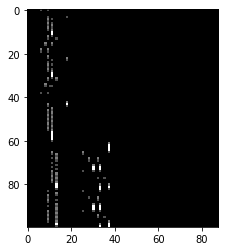

In [41]:
import matplotlib.pyplot as plt
in_img = x_enk_minta[0]
gen_img255 = in_img*255
gen_img_i = gen_img255.astype(np.uint8)
plt.imshow(gen_img_i, cmap='gray')

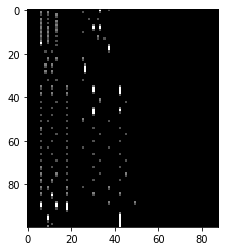

In [42]:
out_img = y_dek_minta[0]
gen_img255 = out_img*255
gen_img_i = gen_img255.astype(np.uint8)
plt.imshow(gen_img_i, cmap='gray')

In [39]:
gen_img.shape

(88, 100)

In [74]:
(x_enk_minta, x_dek_minta), y_dek_minta = next(valid_data_gen)
y_teszt_pred=model.predict([x_enk_minta, x_dek_minta])

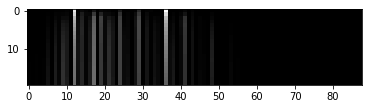

In [79]:
import matplotlib.pyplot as plt
in_img = y_teszt_pred[22]
gen_img255 = in_img*255
gen_img_i = gen_img255.astype(np.uint8)
plt.imshow(gen_img_i, cmap='gray')

In [80]:
from PIL import Image
image = Image.fromarray(gen_img_i, mode = 'L')
image.save('C:/NHF/S2Sgen4.png')

In [37]:
y_teszt_pred[20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.